# **Deep HW3**

**Pantea Amoie    400101656**

### Q3
#### Part a

In [28]:
import torch
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2

# Loading the pretrained MobileNetV2 model
model = mobilenet_v2(pretrained=True)
model.eval()  # Setting model to evaluation mode

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **Structure**

MobileNetV2 is a convolutional neural network architecture designed for mobile and embedded vision applications. It is efficient and lightweight, making it suitable for devices with limited computational resources. The key innovation in MobileNetV2 is the inverted residual block with linear bottlenecks.

Depthwise Separable Convolutions:

A standard convolution is split into a depthwise convolution (per-channel spatial filtering) and a pointwise convolution (combining channels).It reduces computation and parameters.

Inverted Residuals:

Instead of shrinking intermediate feature dimensions (like in ResNets), MobileNetV2 expands the channels inside each residual block.
It first expands the feature dimensions, applies depthwise convolution, and then projects back to a lower-dimensional space.

Linear Bottlenecks:

A linear layer at the end of the residual block avoids activation functions, reducing information loss.
Structure:

The network begins with a regular convolution layer, followed by several inverted residual blocks with varying expansion factors and strides.
Ends with a global average pooling layer and a fully connected (dense) layer for classification.

### **Input**
The typical input dimensions for MobileNetV2 are:

Width × Height × Channels = 224 × 224 × 3

The input is a 3-channel RGB image.

### **Preprocessing**
Resizing the input image to the required dimensions (224 × 224).

Normalization: Scaling pixel values to the range [0, 1] by dividing by 255.
Optionally, subtracting the mean of the ImageNet dataset (if pretrained weights are used):

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

normalized_pixel = (pixel_value - mean) / std

Batch Input: Inputs must be fed as batches with shape (Converting to a PyTorch tensor with shape (3, 224, 224).)

### **Output**
The output of MobileNetV2 depends on the number of classes (n_classes) in the dataset used for training. ImageNet has 1000 classes, so the output dimension is (Batch Size, 1000).
The final layer applies a softmax activation, producing a probability distribution across the n_classes.

#### Part b

In [30]:
from PIL import Image
import torchvision.transforms as transforms
import requests

image = Image.open("cat_.jpg")
input_tensor = preprocess(image).unsqueeze(0)  # Adding batch dimension


with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Top 3 predictions
top3_prob, top3_classes = torch.topk(probabilities, 3)

LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
response = requests.get(LABELS_URL)
imagenet_classes = response.json()

print("Top 3 classes and probabilities:")
for i in range(3):
    class_idx = top3_classes[i].item()
    print(f"Class: {imagenet_classes[class_idx]}, Probability: {top3_prob[i].item():.4f}")


Top 3 classes and probabilities:
Class: tiger cat, Probability: 0.8111
Class: tabby cat, Probability: 0.0948
Class: Egyptian Mau, Probability: 0.0498


#### Part c

In [31]:
from torch import nn

num_classes = 102
model.features.requires_grad_(False)  # Freezing feature extractor
# Classification
model.classifier[1] = nn.Linear(model.last_channel, num_classes)


In [34]:
from torchvision.datasets import Flowers102
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset

# Preprocessing transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_set = Flowers102(root='data', split='train', transform=data_transforms, download=True)
val_set = Flowers102(root='data', split='val', transform=data_transforms, download=True)
test_set = Flowers102(root='data', split='test', transform=data_transforms, download=True)

# Combining all datasets
full_dataset = ConcatDataset([train_set, val_set, test_set])

# Swapping train and test to have more training samples
train_size = 6149
val_size = 1020
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [35]:
import torch
from torch import nn
import torch.optim as optim
from torchvision.models import mobilenet_v2

model = mobilenet_v2(pretrained=True)
model.features.requires_grad_(False)  # Freezing feature extractor
model.classifier[1] = nn.Linear(model.last_channel, 102)  # 102 Flower Classes

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
def train_model(model, train_loader, val_loader, epochs=10):
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}")

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)
        print(f"Epoch {epoch+1}/{epochs} - Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.4f}")

    return train_losses, val_losses, train_acc, val_acc


Epoch 1/10 - Train Loss: 2.1046, Train Accuracy: 0.6027
Epoch 1/10 - Val Loss: 0.7882, Val Accuracy: 0.8588
Epoch 2/10 - Train Loss: 0.5947, Train Accuracy: 0.9006
Epoch 2/10 - Val Loss: 0.4481, Val Accuracy: 0.9176
Epoch 3/10 - Train Loss: 0.3704, Train Accuracy: 0.9377
Epoch 3/10 - Val Loss: 0.3483, Val Accuracy: 0.9216
Epoch 4/10 - Train Loss: 0.2650, Train Accuracy: 0.9553
Epoch 4/10 - Val Loss: 0.3169, Val Accuracy: 0.9245
Epoch 5/10 - Train Loss: 0.2076, Train Accuracy: 0.9636
Epoch 5/10 - Val Loss: 0.2901, Val Accuracy: 0.9235
Epoch 6/10 - Train Loss: 0.1626, Train Accuracy: 0.9761
Epoch 6/10 - Val Loss: 0.2659, Val Accuracy: 0.9343
Epoch 7/10 - Train Loss: 0.1328, Train Accuracy: 0.9790
Epoch 7/10 - Val Loss: 0.2480, Val Accuracy: 0.9245
Epoch 8/10 - Train Loss: 0.1113, Train Accuracy: 0.9841
Epoch 8/10 - Val Loss: 0.2391, Val Accuracy: 0.9333
Epoch 9/10 - Train Loss: 0.1024, Train Accuracy: 0.9859
Epoch 9/10 - Val Loss: 0.2324, Val Accuracy: 0.9363
Epoch 10/10 - Train Loss: 0.

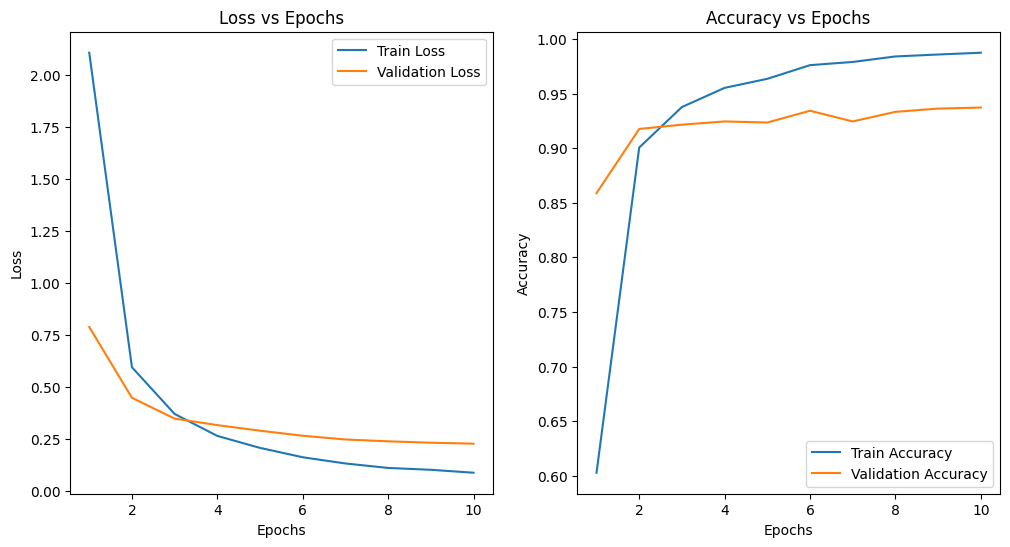

In [36]:
import matplotlib.pyplot as plt

train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader)

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.show()


In [49]:
def evaluate(model, data_loader):
    model.eval()  # Setting the model to evaluation mode
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# After training, evaluating the model on train, validation, and test datasets
train_loss, train_accuracy = evaluate(model, train_loader)
val_loss, val_accuracy = evaluate(model, val_loader)
test_loss, test_accuracy = evaluate(model, test_loader)

print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Training Loss: 0.0307, Training Accuracy: 0.9976
Validation Loss: 0.2279, Validation Accuracy: 0.9373
Test Loss: 0.2526, Test Accuracy: 0.9294


#### Part d

**VGG16**

In [39]:
import torch
from torch import nn
import torch.optim as optim
from torchvision.models import mobilenet_v2, vgg16, resnet50


model_vgg16 = vgg16(pretrained=True)
# Freezing the feature extraction layers
for param in model_vgg16.features.parameters():
    param.requires_grad = False
model_vgg16.classifier[6] = nn.Linear(4096, num_classes)

criterion = nn.CrossEntropyLoss()

def setup_optimizer(model_vgg16, lr=0.001):
    return optim.Adam(filter(lambda p: p.requires_grad, model_vgg16.parameters()), lr=lr)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# Training Loop
def train_model(model, train_loader, val_loader, epochs=10):
    model.to(device)
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    optimizer = setup_optimizer(model)

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}")

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)
        print(f"Epoch {epoch+1}/{epochs} - Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.4f}")

    return train_losses, val_losses, train_acc, val_acc


In [41]:
# Analyzing Number of Parameters
def analyze_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    return total_params, trainable_params


In [42]:
train_losses_vgg, val_losses_vgg, train_acc_vgg, val_acc_vgg = train_model(model_vgg16, train_loader, val_loader, epochs=10)

Epoch 1/10 - Train Loss: 2.8656, Train Accuracy: 0.3545
Epoch 1/10 - Val Loss: 1.2830, Val Accuracy: 0.6931
Epoch 2/10 - Train Loss: 1.6608, Train Accuracy: 0.6329
Epoch 2/10 - Val Loss: 1.0088, Val Accuracy: 0.7480
Epoch 3/10 - Train Loss: 1.4683, Train Accuracy: 0.7250
Epoch 3/10 - Val Loss: 0.9963, Val Accuracy: 0.7676
Epoch 4/10 - Train Loss: 1.5417, Train Accuracy: 0.7670
Epoch 4/10 - Val Loss: 1.1202, Val Accuracy: 0.7765
Epoch 5/10 - Train Loss: 1.7486, Train Accuracy: 0.7813
Epoch 5/10 - Val Loss: 1.1515, Val Accuracy: 0.7784
Epoch 6/10 - Train Loss: 1.5138, Train Accuracy: 0.8248
Epoch 6/10 - Val Loss: 1.2544, Val Accuracy: 0.8000
Epoch 7/10 - Train Loss: 1.7195, Train Accuracy: 0.8364
Epoch 7/10 - Val Loss: 1.3646, Val Accuracy: 0.8020
Epoch 8/10 - Train Loss: 1.8329, Train Accuracy: 0.8463
Epoch 8/10 - Val Loss: 1.5188, Val Accuracy: 0.7961
Epoch 9/10 - Train Loss: 1.7993, Train Accuracy: 0.8663
Epoch 9/10 - Val Loss: 1.5734, Val Accuracy: 0.8304
Epoch 10/10 - Train Loss: 1.

In [43]:
analyze_parameters(model_vgg16)

Total Parameters: 134678438
Trainable Parameters: 119963750


(134678438, 119963750)

In [51]:
train_loss, train_accuracy = evaluate(model_vgg16, train_loader)
val_loss, val_accuracy = evaluate(model_vgg16, val_loader)
test_loss, test_accuracy = evaluate(model_vgg16, test_loader)

print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Training Loss: 0.0654, Training Accuracy: 0.9912
Validation Loss: 1.6172, Validation Accuracy: 0.8255
Test Loss: 2.1611, Test Accuracy: 0.7931


**ResNet50**

In [45]:
model_resnet = resnet50(pretrained=True)

In [46]:
# Freezing the feature extraction layers
for param in model_resnet.parameters():
    param.requires_grad = False
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)

train_losses_resnet, val_losses_resnet, train_acc_resnet, val_acc_resnet = train_model(model_resnet, train_loader, val_loader, epochs=10)

Epoch 1/10 - Train Loss: 2.2642, Train Accuracy: 0.5591
Epoch 1/10 - Val Loss: 0.9000, Val Accuracy: 0.8225
Epoch 2/10 - Train Loss: 0.6301, Train Accuracy: 0.8920
Epoch 2/10 - Val Loss: 0.5105, Val Accuracy: 0.8951
Epoch 3/10 - Train Loss: 0.3824, Train Accuracy: 0.9293
Epoch 3/10 - Val Loss: 0.4073, Val Accuracy: 0.8990
Epoch 4/10 - Train Loss: 0.2663, Train Accuracy: 0.9523
Epoch 4/10 - Val Loss: 0.3645, Val Accuracy: 0.9167
Epoch 5/10 - Train Loss: 0.2103, Train Accuracy: 0.9593
Epoch 5/10 - Val Loss: 0.3411, Val Accuracy: 0.9088
Epoch 6/10 - Train Loss: 0.1696, Train Accuracy: 0.9681
Epoch 6/10 - Val Loss: 0.3216, Val Accuracy: 0.9167
Epoch 7/10 - Train Loss: 0.1296, Train Accuracy: 0.9776
Epoch 7/10 - Val Loss: 0.2877, Val Accuracy: 0.9225
Epoch 8/10 - Train Loss: 0.1131, Train Accuracy: 0.9821
Epoch 8/10 - Val Loss: 0.3007, Val Accuracy: 0.9225
Epoch 9/10 - Train Loss: 0.1010, Train Accuracy: 0.9844
Epoch 9/10 - Val Loss: 0.2790, Val Accuracy: 0.9225
Epoch 10/10 - Train Loss: 0.

In [47]:
analyze_parameters(model_resnet)

Total Parameters: 23717030
Trainable Parameters: 208998


(23717030, 208998)

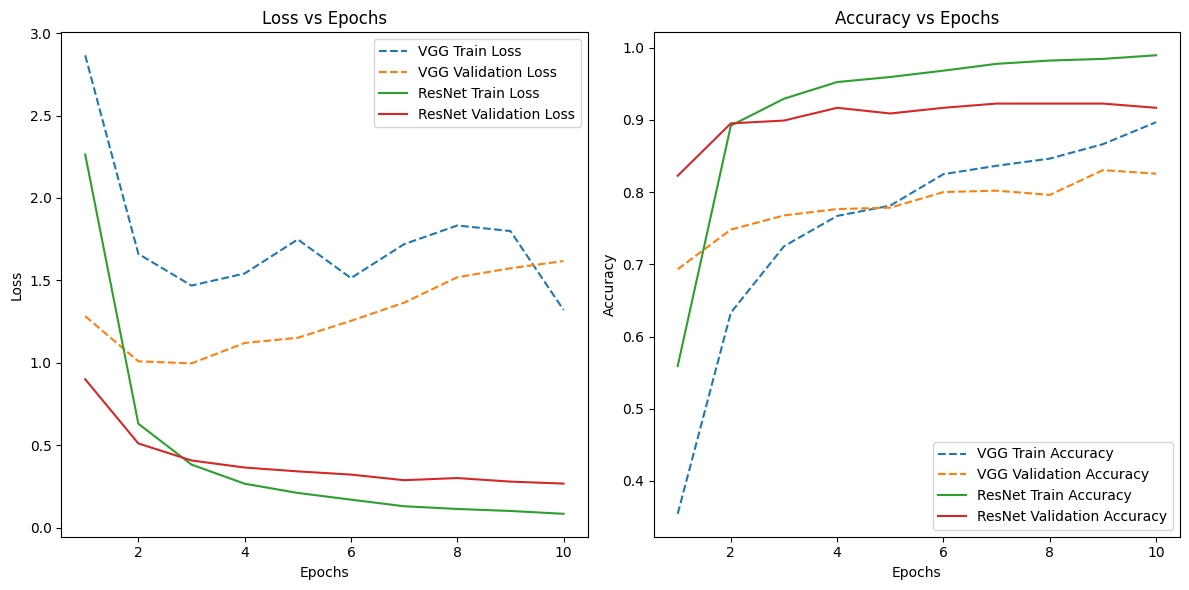

In [48]:
import matplotlib.pyplot as plt

epochs_vgg = range(1, len(train_losses_vgg) + 1)
epochs_resnet = range(1, len(train_losses_resnet) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_vgg, train_losses_vgg, label="VGG Train Loss", linestyle='--')
plt.plot(epochs_vgg, val_losses_vgg, label="VGG Validation Loss", linestyle='--')
plt.plot(epochs_resnet, train_losses_resnet, label="ResNet Train Loss", linestyle='-')
plt.plot(epochs_resnet, val_losses_resnet, label="ResNet Validation Loss", linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_vgg, train_acc_vgg, label="VGG Train Accuracy", linestyle='--')
plt.plot(epochs_vgg, val_acc_vgg, label="VGG Validation Accuracy", linestyle='--')
plt.plot(epochs_resnet, train_acc_resnet, label="ResNet Train Accuracy", linestyle='-')
plt.plot(epochs_resnet, val_acc_resnet, label="ResNet Validation Accuracy", linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

plt.tight_layout()
plt.show()


In [52]:
train_loss, train_accuracy = evaluate(model_resnet, train_loader)
val_loss, val_accuracy = evaluate(model_resnet, val_loader)
test_loss, test_accuracy = evaluate(model_resnet, test_loader)

print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Training Loss: 0.0369, Training Accuracy: 0.9979
Validation Loss: 0.2671, Validation Accuracy: 0.9167
Test Loss: 0.2825, Test Accuracy: 0.9186


### **Analysis**

**Training Performance:**

- MobileNetV2: Training Loss: 0.0307,  Training Accuracy: 0.9976
- VGG16: Training Loss: 0.0654,  Training Accuracy: 0.9912
- ResNet50: Training Loss: 0.0369,  Training Accuracy: 0.9979
   
MobileNetV2 and ResNet50 show high training accuracy (above 99%), with MobileNetV2 having slightly better performance. VGG16 has a lower training accuracy (99.12%) and a higher loss (0.0654), which suggests it may be underperforming during training compared to the other two models.

**Validation Performance:**

- MobileNetV2: Validation Loss: 0.2279,  Validation Accuracy: 0.9373
- VGG16: Validation Loss: 1.6172,  Validation Accuracy: 0.8255
- ResNet50: Validation Loss: 0.2671,  Validation Accuracy: 0.9167

MobileNetV2 outperforms both VGG16 and ResNet50 in validation accuracy (93.73%) and loss (0.2279), showing a better generalization ability on the validation set.

VGG16 has significantly worse validation performance, with a much higher loss (1.6172) and a lower accuracy (82.55%). This suggests that VGG16 may be overfitting or is not suitable for this particular dataset.

ResNet50 has solid performance with 91.67% validation accuracy and a loss of 0.2671, which is slightly worse than MobileNetV2 but better than VGG16.

**Test Performance:**
- MobileNetV2: Test Loss: 0.2526,  Test Accuracy: 0.9294
- VGG16: Test Loss: 2.1611,  Test Accuracy: 0.7931
- ResNet50: Test Loss: 0.2825,  Test Accuracy: 0.9186

Again, MobileNetV2 leads with the best test accuracy (92.94%) and test loss (0.2526), indicating it generalizes best to unseen data.

ResNet50 follows closely with test accuracy of 91.86%, which is also a strong performance.

VGG16 shows the worst performance on the test set, with an accuracy of 79.31% and a high test loss of 2.1611, suggesting severe overfitting.

**Parameters:**
- VGG16: Total Parameters: 134,678,438,  Trainable Parameters: 119,963,750
- ResNet50: Total Parameters: 23,717,030,  Trainable Parameters: 208,998

VGG16 has the largest number of parameters, which can contribute to its overfitting behavior. The large number of parameters suggests it is more prone to memorizing the training data rather than generalizing well.

ResNet50 has significantly fewer parameters than VGG16 (approximately 23 million vs. 134 million), but still performs relatively well. This suggests that ResNet’s architecture with residual connections may help mitigate overfitting.

**MobileNetV2** shows the best overall performance, achieving high accuracy on training, validation. It is a strong candidate for tasks requiring efficient models that generalize well.

**ResNet50** performs slightly worse than **MobileNetV2** but still achieves strong validation and test performance, likely benefiting from its residual connections.

**VGG16**, with its large number of parameters, performs poorly in validation and test accuracy, likely due to overfitting. Despite a good training accuracy, its generalization ability is not as strong as the other models.


#### Part e

In [55]:
import torch
from torch import nn
import torch.optim as optim
from torchvision.models import mobilenet_v2

# Re-initializing MobileNetV2 from scratch
model_scratch = mobilenet_v2(pretrained=False)  # Using random weights instead of pretrained
model_scratch.classifier[1] = nn.Linear(model_scratch.last_channel, 102)  # 102 Flower Classes


In [56]:
# Training Loop
def train_model_scratch(model, train_loader, val_loader, epochs=10):
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}")

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)
        print(f"Epoch {epoch+1}/{epochs} - Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.4f}")

    return train_losses, val_losses, train_acc, val_acc


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scratch.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_scratch.to(device)
# Training the model from scratch
train_losses_scratch, val_losses_scratch, train_acc_scratch, val_acc_scratch = train_model_scratch(model_scratch, train_loader, val_loader)


Epoch 1/10 - Train Loss: 3.9767, Train Accuracy: 0.0950
Epoch 1/10 - Val Loss: 3.4585, Val Accuracy: 0.1441
Epoch 2/10 - Train Loss: 3.2634, Train Accuracy: 0.1781
Epoch 2/10 - Val Loss: 2.9490, Val Accuracy: 0.2667
Epoch 3/10 - Train Loss: 2.8777, Train Accuracy: 0.2560
Epoch 3/10 - Val Loss: 2.8998, Val Accuracy: 0.2794
Epoch 4/10 - Train Loss: 2.5039, Train Accuracy: 0.3279
Epoch 4/10 - Val Loss: 2.7942, Val Accuracy: 0.3186
Epoch 5/10 - Train Loss: 2.2561, Train Accuracy: 0.3926
Epoch 5/10 - Val Loss: 2.4149, Val Accuracy: 0.3578
Epoch 6/10 - Train Loss: 1.9690, Train Accuracy: 0.4539
Epoch 6/10 - Val Loss: 2.0896, Val Accuracy: 0.4363
Epoch 7/10 - Train Loss: 1.8162, Train Accuracy: 0.4973
Epoch 7/10 - Val Loss: 1.9574, Val Accuracy: 0.4833
Epoch 8/10 - Train Loss: 1.5739, Train Accuracy: 0.5575
Epoch 8/10 - Val Loss: 1.9593, Val Accuracy: 0.5078
Epoch 9/10 - Train Loss: 1.3819, Train Accuracy: 0.6011
Epoch 9/10 - Val Loss: 1.7145, Val Accuracy: 0.5412
Epoch 10/10 - Train Loss: 1.

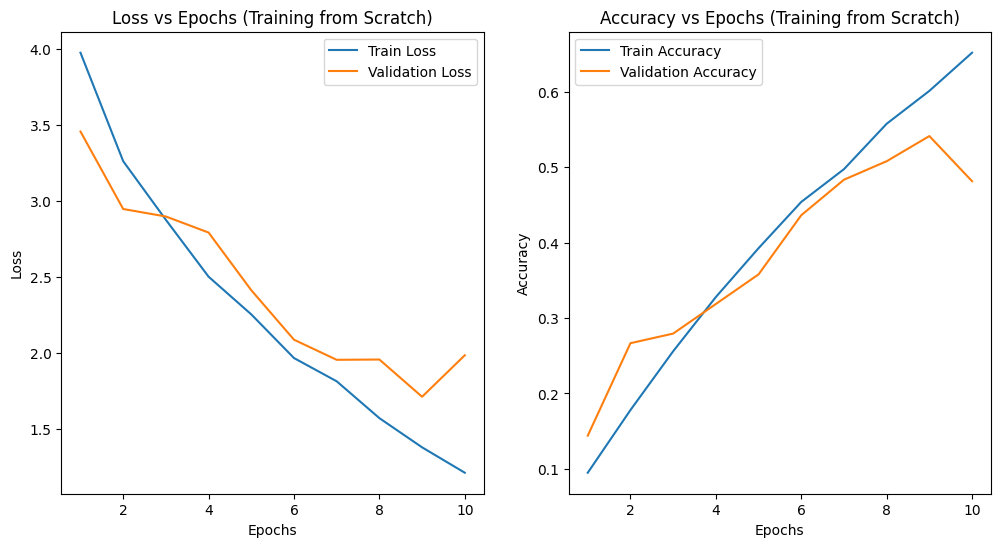

In [57]:
epochs = range(1, len(train_losses_scratch) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_scratch, label="Train Loss")
plt.plot(epochs, val_losses_scratch, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs (Training from Scratch)")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_scratch, label="Train Accuracy")
plt.plot(epochs, val_acc_scratch, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs (Training from Scratch)")
plt.show()

In [58]:
# After training, evaluate the model on train, validation, and test datasets
train_loss_scratch, train_accuracy_scratch = evaluate(model_scratch, train_loader)
val_loss_scratch, val_accuracy_scratch = evaluate(model_scratch, val_loader)
test_loss_scratch, test_accuracy_scratch = evaluate(model_scratch, test_loader)

print(f"Training Loss (Scratch): {train_loss_scratch:.4f}, Training Accuracy (Scratch): {train_accuracy_scratch:.4f}")
print(f"Validation Loss (Scratch): {val_loss_scratch:.4f}, Validation Accuracy (Scratch): {val_accuracy_scratch:.4f}")
print(f"Test Loss (Scratch): {test_loss_scratch:.4f}, Test Accuracy (Scratch): {test_accuracy_scratch:.4f}")


Training Loss (Scratch): 1.3169, Training Accuracy (Scratch): 0.6120
Validation Loss (Scratch): 1.9872, Validation Accuracy (Scratch): 0.4814
Test Loss (Scratch): 2.1205, Test Accuracy (Scratch): 0.4627


### **Analysis**

**Training Loss and Accuracy:**
   - **Previous Model:** The original MobileNetV2 model achieved very low training loss and a high training accuracy.
   - **Trained from Scratch:** In the new model, the training loss is much higher and training accuracy is significantly lower.
   
The large increase in training loss and the dramatic drop in training accuracy indicate that training the model from scratch is significantly harder. The pre-trained MobileNetV2 model likely benefited from previously learned features, leading to better performance. When training from scratch, the network starts with random weights and needs more epochs and careful tuning to reach high performance.

**Validation Loss and Accuracy:**
   - **Previous Model:** The validation loss was 0.2279 and validation accuracy was 93.73%.
   - **Trained from Scratch:** The validation loss has increased to 1.9872, and the validation accuracy dropped to 48.14%.
   
There's a significant increase in validation loss and a sharp drop in validation accuracy, suggesting that the model struggles to generalize from scratch. This is typical when a model is not initialized with useful pre-trained features, as it has to learn everything from random weights and often overfits or underperforms in the early stages of training.

**Test Loss and Accuracy:**
   - **Previous Model:** The test performance was strong with a test loss of 0.2526 and test accuracy of 92.94%.
   - **Trained from Scratch:** Test loss has risen to 2.1205, and test accuracy has dropped to 46.27%.
   
The test performance shows a similar trend to the validation set, with a large drop in accuracy and a significant increase in loss. This suggests that the model trained from scratch is not generalizing well to unseen data. Without pre-trained features, it struggles to perform well on new data, reflecting the importance of pre-training in transfer learning.

**Therefore:**

**Pre-trained MobileNetV2** performs significantly better than **training from scratch**, both in terms of training, validation, and test accuracy. The pre-trained model benefits from learned features from a larger dataset (e.g., ImageNet), allowing it to generalize well from the start
.
**Training from scratch** yields much poorer results, likely because the model needs more time and data to learn meaningful features, and without any prior knowledge, it cannot achieve the same level of performance as the pre-trained model.


**We also tried training with 20 epochs instead of 10, because the base model is not pretrained and is being trained from scrath, it needs more epochs:**

In [60]:
# Training Loop
def train_model_scratch(model, train_loader, val_loader, epochs=20):
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}")

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)
        print(f"Epoch {epoch+1}/{epochs} - Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.4f}")

    return train_losses, val_losses, train_acc, val_acc


# Re-initializing MobileNetV2 from scratch
model_scratch = mobilenet_v2(pretrained=False)  # Using random weights instead of pretrained
model_scratch.classifier[1] = nn.Linear(model_scratch.last_channel, 102)  # 102 Flower Classes

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scratch.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_scratch.to(device)

# Training the model from scratch
train_losses_scratch, val_losses_scratch, train_acc_scratch, val_acc_scratch = train_model_scratch(model_scratch, train_loader, val_loader)


Epoch 1/20 - Train Loss: 4.0551, Train Accuracy: 0.0878
Epoch 1/20 - Val Loss: 3.6616, Val Accuracy: 0.1245
Epoch 2/20 - Train Loss: 3.2881, Train Accuracy: 0.1760
Epoch 2/20 - Val Loss: 3.7604, Val Accuracy: 0.1324
Epoch 3/20 - Train Loss: 2.8783, Train Accuracy: 0.2474
Epoch 3/20 - Val Loss: 2.7891, Val Accuracy: 0.2755
Epoch 4/20 - Train Loss: 2.5448, Train Accuracy: 0.3179
Epoch 4/20 - Val Loss: 2.8294, Val Accuracy: 0.3137
Epoch 5/20 - Train Loss: 2.2329, Train Accuracy: 0.3895
Epoch 5/20 - Val Loss: 3.0333, Val Accuracy: 0.2843
Epoch 6/20 - Train Loss: 1.9691, Train Accuracy: 0.4506
Epoch 6/20 - Val Loss: 2.2161, Val Accuracy: 0.4167
Epoch 7/20 - Train Loss: 1.7001, Train Accuracy: 0.5215
Epoch 7/20 - Val Loss: 2.0039, Val Accuracy: 0.4578
Epoch 8/20 - Train Loss: 1.4811, Train Accuracy: 0.5729
Epoch 8/20 - Val Loss: 1.7281, Val Accuracy: 0.5284
Epoch 9/20 - Train Loss: 1.2522, Train Accuracy: 0.6385
Epoch 9/20 - Val Loss: 2.0475, Val Accuracy: 0.4598
Epoch 10/20 - Train Loss: 1.

As we expected, the model reaches higher accuracy by training on more epochs.

But it still has less accuracy than the pretrained model.

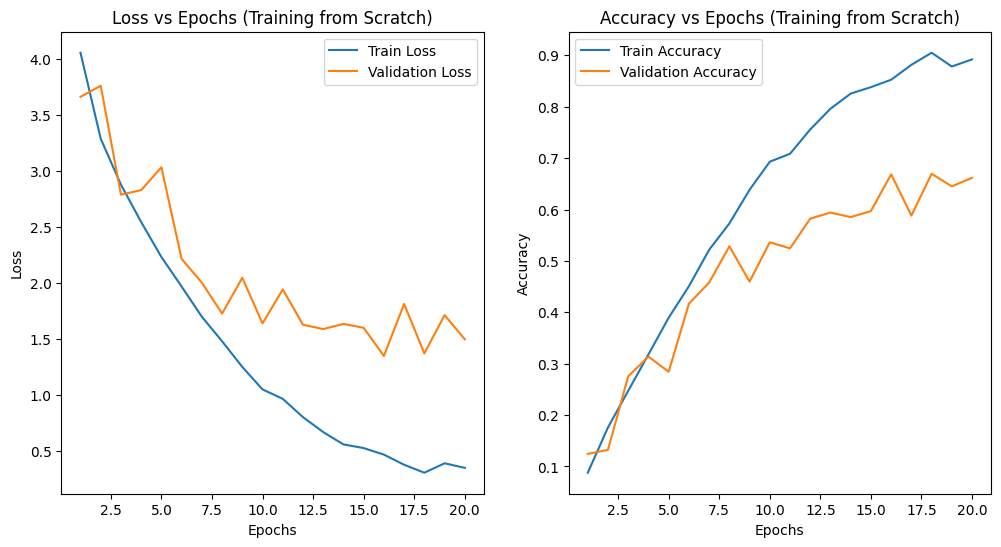

In [61]:
epochs = range(1, len(train_losses_scratch) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_scratch, label="Train Loss")
plt.plot(epochs, val_losses_scratch, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs (Training from Scratch)")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_scratch, label="Train Accuracy")
plt.plot(epochs, val_acc_scratch, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs (Training from Scratch)")
plt.show()

In [62]:
# After training, evaluate the model on train, validation, and test datasets
train_loss_scratch, train_accuracy_scratch = evaluate(model_scratch, train_loader)
val_loss_scratch, val_accuracy_scratch = evaluate(model_scratch, val_loader)
test_loss_scratch, test_accuracy_scratch = evaluate(model_scratch, test_loader)

print(f"Training Loss (Scratch): {train_loss_scratch:.4f}, Training Accuracy (Scratch): {train_accuracy_scratch:.4f}")
print(f"Validation Loss (Scratch): {val_loss_scratch:.4f}, Validation Accuracy (Scratch): {val_accuracy_scratch:.4f}")
print(f"Test Loss (Scratch): {test_loss_scratch:.4f}, Test Accuracy (Scratch): {test_accuracy_scratch:.4f}")


Training Loss (Scratch): 0.1959, Training Accuracy (Scratch): 0.9379
Validation Loss (Scratch): 1.4987, Validation Accuracy (Scratch): 0.6618
Test Loss (Scratch): 1.4036, Test Accuracy (Scratch): 0.6745
